# RAG PDF Chatbot

A multi-turn conversational AI backend powered by Retrieval-Augmented Generation (RAG). Users can upload PDF documents and interact with them through chat.


## 0. Setup 

###  LangSmith Tracing
After signing up at LangSmith, make sure to set your environment variable to start logging traces:
```
export LANGSMITH_TRACING="true"
export LANGSMITH_API_KEY="..."
```
or, you can set them manually in a notebook


In [1]:
import getpass 
import os

os.environ["LANGSMITH_TRACING"] = "true" 
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


### Get `.env` variable for LLM API Key


In [2]:
from dotenv import load_dotenv

load_dotenv() 

gemini_api_key = os.getenv("GEMINI_API_KEY")

if gemini_api_key is None:
    raise ValueError("GEMINI_API_KEY not found. Please set it up in the .env file")

### Initialize the model

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI 

model = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash", 
    temperature = 0, 
    api_key = gemini_api_key
)

## 1. Indexing 

### Select embeddings model 

I've chosen HuggingFace sentence-transformers `all-mpnet-base-v2` embedding, you can choose others like Gemini, OpenAI, MistralAI, etc.

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings 

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

If GoogleGenerativeAIEmbeddings is used: 

```python
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "service_account.json"

import json
import os

# Load the project ID dynamically from the credentials file
with open(os.environ["GOOGLE_APPLICATION_CREDENTIALS"], "r") as f:
    credentials = json.load(f)
    project_id = credentials["project_id"]

# Now use it when initializing the embeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
    project=project_id
)
```

### Loading documents

In [5]:
import os 
from langchain.document_loaders import PyPDFLoader 
from PyPDF2 import PdfReader 
import pytesseract 
from pdf2image import convert_from_path 
from langchain.schema import Document 

def load_pdf(file_path): 
    """Load a PDF with OCR fallback for scanned PDFs"""
    documents = [] 

    try: 
        # Try normal text extraction 
        loader = PyPDFLoader(file_path) 
        documents = loader.load() 

        # Check if extraction was empty (possibility of scanned PDF) 
        if all(len(doc.page_content.strip()) == 0 for doc in documents): 
            raise ValueError("No text found, using OCR fallback.") 

    except Exception: 
        # OCR fallback 
        print(f"[OCR] Processing scanned PDF") 
        images = convert_from_path(file_path) 
        text_pages = [] 
        for img in images: 
            text = pytesseract.image_to_string(img) 
            text_pages.append(text) 

        documents = [
            Document(page_content=page_text, metadata={"source": file_path, "page": i+1})
            for i, page_text in enumerate(text_pages)
        ]

    return documents 

docs = load_pdf("D:\AML-CFT.pdf")
    

<>:37: SyntaxWarning: invalid escape sequence '\A'
<>:37: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Dipesh\AppData\Local\Temp\ipykernel_16744\625410551.py:37: SyntaxWarning: invalid escape sequence '\A'
  docs = load_pdf("D:\AML-CFT.pdf")


### Select vector store

I am using FAISS but you can choose others such as Pinecone, Qdrant

In [6]:
import faiss 
from langchain_community.docstore.in_memory import InMemoryDocstore 
from langchain_community.vectorstores import FAISS 

embedding_dim = len(embeddings.embed_query("Hello world")) 
index =  faiss.IndexFlatL2(embedding_dim) 

vector_store = FAISS(
    embedding_function=embeddings, 
    index=index, 
    docstore=InMemoryDocstore(), 
    index_to_docstore_id={}
)

### Splitting documents

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Split into chunks 
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, 
                                               chunk_overlap=200, 
                                              add_start_index=True) 
all_splits = text_splitter.split_documents(docs)
print(f"Split document into {len(all_splits)} sub-documents.") 


Split document into 39 sub-documents.


### Storing Documents

In [8]:
# Add to existing vector store 
document_ids = vector_store.add_documents(documents=all_splits) 
print(document_ids[:3])

['fb6d8f02-0ace-413d-aab6-2dbcc1a37318', '8a44d369-a42b-4197-874a-652d3ab2bc66', '11eac783-814c-4dca-93d6-a7531e5dc847']


## 2. Retrieval and Generation

In [9]:
from langchain import hub    

# Prompt for Question Answering 
prompt = hub.pull("rlm/rag-prompt") 

example_message = prompt.invoke(
    {"context": "(content goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_message) == 1
print(example_message[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (content goes here) 
Answer:


- `hub` is LangChain’s “prompt repository” client — it can fetch ready-made, community-shared prompt templates (like GitHub but for prompts).
- The hub has prompts for tasks like RAG, summarization, translation, etc.
- This avoids rewriting the same boilerplate instructions for the LLM.

In [10]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict 

class State(TypedDict): 
    question: str 
    context: List[Document] 
    answer: str 


### Nodes

In [11]:
def retrieve(state: State): 
    retrieved_docs = vector_store.similarity_search(state["question"]) 
    return {"context": retrieved_docs} 

def generate(state: State): 
    docs_content = "n\n".join(doc.page_content for doc in state["context"]) 
    messages = prompt.invoke({"question": state["question"], "context": docs_content}) 
    response = model.invoke(messages)
    return {"answer": response.content}

### Graph

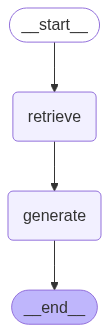

In [12]:
from langgraph.graph import START, StateGraph 
from IPython.display import Image, display

graph_builder = StateGraph(State).add_sequence([retrieve, generate]) 
graph_builder.add_edge(START, "retrieve") 
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke

In [13]:
result = graph.invoke({"question": "What is money laundering"})

In [26]:
print(f"Context: {result["context"]}\n")
print(f"Answer: {result["answer"]}")

Context: [Document(metadata={'source': 'D:\\AML-CFT.pdf', 'page': 0, 'start_index': 0}, page_content='FREQUENTLY ASKED QUESTIONS On AML/CFT \n1. What is Money Laundering? \nMoney Laundering is the process by which illegal funds and assets are converted into legitimate \nfunds and assets. \n2. What is the current scale of Money Laundering worldwide? \nMeasuring the current scale of money laundering is extremely difficult. The World Bank and IMF have \nestimated volume of money laundering to between 3 and 5 percent of global gross domestic product \n(GDP) equivalent to approximately US$2.2 trillion to US$3.7 trillion annually. \n3. How does money laundering work? \nMoney laundering works in following three stages. \n1. Placement: Illegal funds or assets are first brought into the financial system. This \nplacement makes the funds more liquid. Money launderers place illegal  funds using a \nvariety of techniques like, depositing cash into bank accounts or purchasing insurance \nproducts a

## Query Analysis